In [2]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#!apt-get update

# download spark3.0.1
#!wget -q http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.1-bin-hadoop3.2.tgz

!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz


# unzip it
!tar xf spark-3.0.2-bin-hadoop3.2.tgz

#!pip install py4j

# install findspark 
!pip install -q findspark

# environmental variable of java and spark was set
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

import findspark
findspark.init()


In [3]:
# Creating spark session

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Sentiment_analysis').getOrCreate()

In [4]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

from pyspark.sql.functions import *
from pyspark.sql.types import *

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [5]:
# Uploading files from local disk

from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [6]:
# Train CSV
tweets_csv = spark.read.csv("train.csv", inferSchema = True, header = True)
print("Train CSV:- ")
tweets_csv.show()

# Test CSV
tweets_test_csv = spark.read.csv("test.csv", inferSchema = True, header = True)
print("Test CSV:- ")
tweets_test_csv.show()

Train CSV:- 
+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows

Test CSV:- 
+-----+--------------------+
|   id|               tweet|
+-----+--------------------+
|31963|#studiolife #aisl...|
|31964| @user #white #su...|
|31965|safe 

In [25]:
# Conversion from SQL dataframe to pandas dataframe

tweets_csv_pandas = tweets_csv.toPandas()
tweets_csv_pandas.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [39]:
import re
def clean_tweet(tweet):
  return ' '.join(re.sub('(@#[A-Za-z0-9]+)|([0-9A-Za-z \t])',' ', tweet).split())

In [40]:
tweets_csv_pandas['clean_tweet'] = tweets_csv_pandas['tweet'].apply(lambda x: clean_tweet(x))

In [56]:
n=11
print("Original tweets:\n"+ tweets_csv_pandas['tweet'][n])
print()

print("Clean tweet:\n"+ tweets_csv_pandas['clean_tweet'][n])
print()

Original tweets:
we are so selfish. #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreaking   #values #love #

Clean tweet:
. # # # # # # # # # #



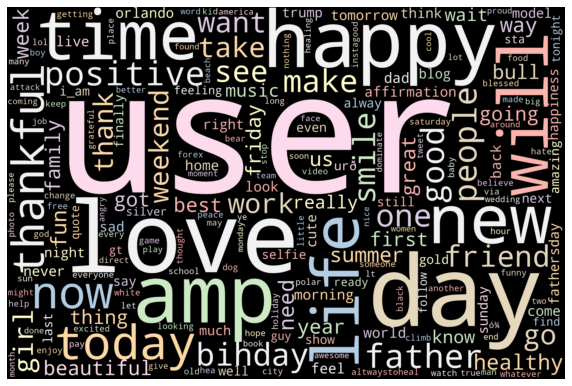

In [51]:
all_tweets = ' '.join(tweet for tweet in tweets_csv_pandas['tweet'])

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Pastel1',
                      collocations=False, stopwords = STOPWORDS).generate(all_tweets)

# Plotting of wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

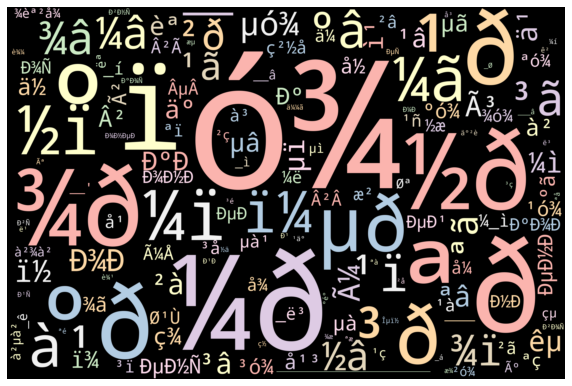

In [54]:
clean_all_tweets = ' '.join(tweet for tweet in tweets_csv_pandas['clean_tweet'])

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Pastel1',
                      collocations=False, stopwords = STOPWORDS).generate(clean_all_tweets)

# Plotting of wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [7]:
# Splitting of Train CSV intp training_data and testing_data

training_data, testing_data = tweets_csv.randomSplit([0.7,0.3], seed = 2018)
print("Training Dataset Count: " + str(training_data.count()))
print("Testing Dataset Count: " + str(testing_data.count()))

Training Dataset Count: 22418
Testing Dataset Count: 9544


In [8]:
# Tokenizer helps in splitting of the tweets/sentence 

tokenizer = Tokenizer(inputCol = 'tweet', outputCol = 'tweet_Words')
tokenizedTrain = tokenizer.transform(training_data)
tokenizedTrain.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|         tweet_Words|
+---+-----+--------------------+--------------------+
|  2|    0|@user @user thank...|[@user, @user, th...|
|  3|    0|  bihday your maj...|[, , bihday, your...|
|  4|    0|#model   i love u...|[#model, , , i, l...|
|  5|    0| factsguide: soci...|[, factsguide:, s...|
|  6|    0|[2/2] huge fan fa...|[[2/2], huge, fan...|
|  7|    0| @user camping to...|[, @user, camping...|
|  8|    0|the next school y...|[the, next, schoo...|
| 10|    0| @user @user welc...|[, @user, @user, ...|
| 11|    0| â #ireland con...|[, â, #ireland,...|
| 14|    1|@user #cnn calls ...|[@user, #cnn, cal...|
| 15|    1|no comment!  in #...|[no, comment!, , ...|
| 16|    0|ouch...junior is ...|[ouch...junior, i...|
| 18|    1|retweet if you ag...|[retweet, if, you...|
| 19|    0|its #friday! ð...|[its, #friday!, ð...|
| 21|    0|#euro2016 people ...|[#euro2016, peopl...|
| 22|    0|sad little dude..

In [9]:
# Stop word remover filters out stop words from input

swr = StopWordsRemover(inputCol = tokenizer.getOutputCol(), outputCol = "Meaningful_Words")
swr_train = swr.transform(tokenizedTrain)
swr_train.show()

+---+-----+--------------------+--------------------+--------------------+
| id|label|               tweet|         tweet_Words|    Meaningful_Words|
+---+-----+--------------------+--------------------+--------------------+
|  2|    0|@user @user thank...|[@user, @user, th...|[@user, @user, th...|
|  3|    0|  bihday your maj...|[, , bihday, your...|[, , bihday, maje...|
|  4|    0|#model   i love u...|[#model, , , i, l...|[#model, , , love...|
|  5|    0| factsguide: soci...|[, factsguide:, s...|[, factsguide:, s...|
|  6|    0|[2/2] huge fan fa...|[[2/2], huge, fan...|[[2/2], huge, fan...|
|  7|    0| @user camping to...|[, @user, camping...|[, @user, camping...|
|  8|    0|the next school y...|[the, next, schoo...|[next, school, ye...|
| 10|    0| @user @user welc...|[, @user, @user, ...|[, @user, @user, ...|
| 11|    0| â #ireland con...|[, â, #ireland,...|[, â, #ireland,...|
| 14|    1|@user #cnn calls ...|[@user, #cnn, cal...|[@user, #cnn, cal...|
| 15|    1|no comment!  i

In [57]:
# converts tweets to vector

hashTF = HashingTF(inputCol = swr.getOutputCol(), outputCol = "features")
numeric_train_data = hashTF.transform(swr_train).select('Meaningful_Words', 'features', 'label')
numeric_train_data.show() 

+--------------------+--------------------+-----+
|    Meaningful_Words|            features|label|
+--------------------+--------------------+-----+
|[@user, @user, th...|(262144,[3824,118...|    0|
|[, , bihday, maje...|(262144,[120737,1...|    0|
|[#model, , , love...|(262144,[19056,44...|    0|
|[, factsguide:, s...|(262144,[16578,23...|    0|
|[[2/2], huge, fan...|(262144,[31097,40...|    0|
|[, @user, camping...|(262144,[11879,29...|    0|
|[next, school, ye...|(262144,[43994,54...|    0|
|[, @user, @user, ...|(262144,[11879,19...|    0|
|[, â, #ireland,...|(262144,[28227,38...|    0|
|[@user, #cnn, cal...|(262144,[11879,18...|    1|
|[comment!, , #aus...|(262144,[5870,248...|    1|
|[ouch...junior, a...|(262144,[71088,72...|    0|
|   [retweet, agree!]|(262144,[20326,13...|    1|
|[#friday!, ð, ...|(262144,[11879,63...|    0|
|[#euro2016, peopl...|(262144,[8421,912...|    0|
|[sad, little, dud...|(262144,[30150,79...|    0|
|[product, day:, h...|(262144,[19247,33...|    0|


In [11]:
# LogisticRegression algorithm is used

lr = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 10)
lr_model = lr.fit(numeric_train_data)
print("Training on train_data using Logistic regression is done !")

Training on train_data using Logistic regression is done !


In [12]:
# Linear support vector algorithm is used

lsvc = LinearSVC(labelCol = "label",featuresCol='features', maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(numeric_train_data)
print("Training on train_data using SVM is done !")


Training on train_data using SVM is done !


In [13]:
# Working on testing_data

tokenizedTest = tokenizer.transform(testing_data)
swr_test = swr.transform(tokenizedTest)
numeric_test_data = hashTF.transform(swr_test).select("label", "Meaningful_Words", "features")
numeric_test_data.show()

+-----+--------------------+--------------------+
|label|    Meaningful_Words|            features|
+-----+--------------------+--------------------+
|    0|[, @user, father,...|(262144,[11879,26...|
|    0|[won!!!, love, la...|(262144,[11334,29...|
|    0|[selfish., #orlan...|(262144,[17060,95...|
|    0|[get, see, daddy,...|(262144,[8538,146...|
|    0|[thankful, paner....|(262144,[23177,36...|
|    0|[know,, essential...|(262144,[35415,73...|
|    1|[@user, @user, lu...|(262144,[11879,45...|
|    0|[never, chance, v...|(262144,[49918,10...|
|    0|[, @user, rip, fe...|(262144,[8411,912...|
|    0|[hard, monday, du...|(262144,[2437,289...|
|    0|[#taylorswift1989...|(262144,[95411,14...|
|    0|[thankful, sunshi...|(262144,[23177,84...|
|    0|[life, social, ne...|(262144,[303,4920...|
|    0|[mom, shares, bih...|(262144,[8538,118...|
|    0|[best, pa, life, ...|(262144,[8421,992...|
|    0|[christina, grimm...|(262144,[5381,118...|
|    0|[@user, wife, ado...|(262144,[11879,35...|


In [ ]:
# Using logistic regression model for prediction on testing_data

prediction = lr_model.transform(numeric_test_data)
prediction_final = prediction.select("Meaningful_Words", "label", "Prediction")

prediction_final.show()

correct_prediction = prediction_final.filter(prediction_final['prediction'] == prediction_final['label']).count() 

total_data = prediction_final.count()

print("Correct prediction: ", correct_prediction, ", total data: ", total_data, ", accuracy: ", correct_prediction/total_data)

+--------------------+-----+----------+
|    Meaningful_Words|label|Prediction|
+--------------------+-----+----------+
|[, @user, father,...|    0|       0.0|
|[won!!!, love, la...|    0|       0.0|
|[selfish., #orlan...|    0|       0.0|
|[get, see, daddy,...|    0|       0.0|
|[thankful, paner....|    0|       0.0|
|[know,, essential...|    0|       0.0|
|[@user, @user, lu...|    1|       0.0|
|[never, chance, v...|    0|       0.0|
|[, @user, rip, fe...|    0|       0.0|
|[hard, monday, du...|    0|       0.0|
|[#taylorswift1989...|    0|       0.0|
|[thankful, sunshi...|    0|       0.0|
|[life, social, ne...|    0|       0.0|
|[mom, shares, bih...|    0|       0.0|
|[best, pa, life, ...|    0|       0.0|
|[christina, grimm...|    0|       0.0|
|[@user, wife, ado...|    0|       0.0|
|[ð©the, white, ...|    1|       1.0|
|[good, morning!, ...|    0|       0.0|
|[aced, first, tes...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows

Correct predic

In [ ]:
# Using linear support vector machines for prediction on testing_data

pred_lsvc = lsvcModel.transform(numeric_test_data)
pred_lsvc_final = pred_lsvc.select("Meaningful_Words", "label", "Prediction")

pred_lsvc_final.show()

correct_pred_lsvc = pred_lsvc_final.filter(pred_lsvc_final['prediction'] == pred_lsvc_final['label']).count() 

total_data_lsvc = pred_lsvc_final.count()

print("Correct prediction: ", correct_pred_lsvc, ", total data: ", total_data_lsvc, ", accuracy: ", correct_pred_lsvc/total_data_lsvc)

+--------------------+-----+----------+
|    Meaningful_Words|label|Prediction|
+--------------------+-----+----------+
|[, @user, father,...|    0|       0.0|
|[won!!!, love, la...|    0|       0.0|
|[selfish., #orlan...|    0|       0.0|
|[get, see, daddy,...|    0|       0.0|
|[thankful, paner....|    0|       0.0|
|[know,, essential...|    0|       0.0|
|[@user, @user, lu...|    1|       1.0|
|[never, chance, v...|    0|       0.0|
|[, @user, rip, fe...|    0|       0.0|
|[hard, monday, du...|    0|       0.0|
|[#taylorswift1989...|    0|       0.0|
|[thankful, sunshi...|    0|       0.0|
|[life, social, ne...|    0|       0.0|
|[mom, shares, bih...|    0|       0.0|
|[best, pa, life, ...|    0|       0.0|
|[christina, grimm...|    0|       0.0|
|[@user, wife, ado...|    0|       0.0|
|[ð©the, white, ...|    1|       1.0|
|[good, morning!, ...|    0|       0.0|
|[aced, first, tes...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows

Correct predic

**Working on test csv data.**

In [ ]:
# Tokenizing, stop word removing and hashing of the test csv dataset

tokenizer_test_csv = Tokenizer(inputCol = 'tweet', outputCol = 'tweet_Words')
tokenized = tokenizer.transform(tweets_test_csv)

swr_test_csv = StopWordsRemover(inputCol = tokenizer_test_csv.getOutputCol(), outputCol = "Meaningful_Words")
swr = swr_test_csv.transform(tokenized)

hashTF_test_csv = HashingTF(inputCol = swr_test_csv.getOutputCol(), outputCol = "features")
numeric = hashTF_test_csv.transform(swr).select('Meaningful_Words', 'features')
numeric.show() 

+--------------------+--------------------+
|    Meaningful_Words|            features|
+--------------------+--------------------+
|[#studiolife, #ai...|(262144,[25986,70...|
|[, @user, #white,...|(262144,[8538,857...|
|[safe, ways, heal...|(262144,[11018,15...|
|[hp, cursed, chil...|(262144,[53146,55...|
|[, , 3rd, #bihday...|(262144,[40394,63...|
|[choose, , , :), ...|(262144,[19528,46...|
|[something, insid...|(262144,[4472,844...|
|[#finished#tattoo...|(262144,[14254,58...|
|[, @user, @user, ...|(262144,[11879,71...|
|[#delicious, , , ...|(262144,[43875,12...|
|[1000dayswasted, ...|(262144,[2035,386...|
|[one, world's, gr...|(262144,[21823,49...|
|[half, way, websi...|(262144,[17252,51...|
|[good, food,, goo...|(262144,[36957,39...|
|[stand, behind, #...|(262144,[15973,49...|
|[ate,i, ate, ate....|(262144,[7242,265...|
|[, @user, got, @u...|(262144,[11879,21...|
|[&amp;, #love, &a...|(262144,[12980,32...|
|[ð­ðð, #g...|(262144,[6099,239...|
|[thought, factory...|(262144,[3

In [ ]:
# Prediction using logistic regression model on test csv dataset

pred_test_csv = lr_model.transform(numeric)
pred_final_test = pred_test_csv.select("Meaningful_Words", "Prediction")
pred_final_test.show()

+--------------------+----------+
|    Meaningful_Words|Prediction|
+--------------------+----------+
|[#studiolife, #ai...|       0.0|
|[, @user, #white,...|       0.0|
|[safe, ways, heal...|       0.0|
|[hp, cursed, chil...|       0.0|
|[, , 3rd, #bihday...|       0.0|
|[choose, , , :), ...|       0.0|
|[something, insid...|       0.0|
|[#finished#tattoo...|       0.0|
|[, @user, @user, ...|       0.0|
|[#delicious, , , ...|       0.0|
|[1000dayswasted, ...|       0.0|
|[one, world's, gr...|       0.0|
|[half, way, websi...|       0.0|
|[good, food,, goo...|       0.0|
|[stand, behind, #...|       0.0|
|[ate,i, ate, ate....|       0.0|
|[, @user, got, @u...|       0.0|
|[&amp;, #love, &a...|       0.0|
|[ð­ðð, #g...|       0.0|
|[thought, factory...|       1.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
# Prediction using linear support vector machines model on test csv dataset

pred_test_csv_svc = lsvcModel.transform(numeric)
pred_final_test_svc = pred_test_csv_svc.select("Meaningful_Words", "Prediction")
pred_final_test_svc.show()

+--------------------+----------+
|    Meaningful_Words|Prediction|
+--------------------+----------+
|[#studiolife, #ai...|       0.0|
|[, @user, #white,...|       0.0|
|[safe, ways, heal...|       0.0|
|[hp, cursed, chil...|       0.0|
|[, , 3rd, #bihday...|       0.0|
|[choose, , , :), ...|       0.0|
|[something, insid...|       0.0|
|[#finished#tattoo...|       0.0|
|[, @user, @user, ...|       0.0|
|[#delicious, , , ...|       0.0|
|[1000dayswasted, ...|       0.0|
|[one, world's, gr...|       0.0|
|[half, way, websi...|       0.0|
|[good, food,, goo...|       0.0|
|[stand, behind, #...|       0.0|
|[ate,i, ate, ate....|       0.0|
|[, @user, got, @u...|       0.0|
|[&amp;, #love, &a...|       0.0|
|[ð­ðð, #g...|       0.0|
|[thought, factory...|       1.0|
+--------------------+----------+
only showing top 20 rows

